In [16]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDepictor
from rdkit.Chem import AllChem
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import rdkit
import xlrd
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

In [17]:
def GetDiffusivity(smi):
    #get molecular weight
    mw=Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
    
    #get molar mass for air
    #a_mass=(1.55/mw**0.65)
    #get molar mass for water
    #w_mass=(2.7E-4)/(mw**0.71)
        
    #get van der waal volume (molecular volume)    
    mol=Chem.AddHs(Chem.MolFromSmiles(smi))
    AllChem.EmbedMolecule(mol)
    vol=Chem.AllChem.ComputeMolVolume(mol)


    #constants
    #n=8.90E-04 #dynamic viscosity of water, 25C Pa*s units
    n=0.890 #dynamic visocity of water ,25C cP units
    w_mass=18.015 #molar mass of water
    T=298 #temp in K
    k=1.38E-23 #boltzman constant in kg-m2/s2-K
    pi=3.1415926
    X=2.6 #constant that depends on solvent, this is the constant for water
    
     #calculate FSG (air) diffusivity coefficinent
    FSG=10**-3*((T**1.75*((1/28.97)+(1/mw))**0.5)/(20.1**(1/3)+(vol**(1/3)))**2)
    
    #calculate Wilke-Chang (water) diffusivity coefficinent
    WC=(7.4E-8)*((((X*w_mass)**0.5)*T)/(n*((vol)**0.6)))
    
     #calculate Hayduk-Laudie (water) diffusivity coefficinent
    HL=13.26E-5/((n**1.4)*((vol)**0.589))
    
    return FSG,WC, HL

In [18]:
old_water=pd.read_excel('DiffusivityCalculationResults.xlsx',sheet_name='Hayduk&Laudie1974_Water')
old_air=pd.read_excel('DiffusivityCalculationResults.xlsx',sheet_name='Fuller_etal_1966_Air')
new=pd.read_excel('JL_ExperimentalData_v3_out.xlsx')

In [19]:
old_water.rename(columns={'diffCoe_SPARC':'DiffCoe_SPARC'},inplace=True)
new.drop(['Index'],axis=1,inplace=True)
new.rename(columns={'Literature':'ObsD'},inplace=True)
new_air=new[new['System']=='air']
new_air.drop(['WilkeChang_SPARC','WilkeChang_ChemAxon','WilkeChang_rdkit','WilkeChang_Mordred'],axis=1,inplace=True)
new_water=new[new['System']=='water']

C:\Users\LSHIELDS\AppData\Local\Temp\ipykernel_14400\3370062416.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_air.drop(['WilkeChang_SPARC','WilkeChang_ChemAxon','WilkeChang_rdkit','WilkeChang_Mordred'],axis=1,inplace=True)


In [20]:
old_air.rename(columns={'OBS_DiffusionCoefficient (cm^2/sec)':'ObsD','SYSTEM':'System'},inplace=True)
old_air

,System,COMPOUND,SMILES,REF,TEMP(K),ObsD,MolWt,vdwVolume_rdkit,MolarVol_air_rdkit,MolarMass_air,...,vdwVolume_ChemAxon,Fuller_ChemAxon,MolarVol_air_ChemAxon,vdwVolume_Mordred,Fuller_Mordred,MolarVol_air_Mordred,vdwVolume_SPARC,DiffCoe_SPARC,Fuller_SPARC,MolarVol_air_SPARC
0,H2,HE,[He],17,298.2,1.132,4.002603,10.920,0.410360,0.629229,...,11.494,0.460901,0.395297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H2,D2,[2H][2H],19,288.2,1.240,4.028204,10.104,0.434298,0.626627,...,10.107,0.449943,0.434204,8.556459,0.472266,0.490335,NaN,NaN,NaN,NaN
2,H2,D2,[2H][2H],27,295.5,1.250,4.028204,10.136,0.433297,0.626627,...,10.107,0.470077,0.434204,8.556459,0.493399,0.490335,NaN,NaN,NaN,NaN
3,H2,N2,N#N,47,193.0,0.368,28.006148,25.352,0.221891,0.177671,...,23.566,0.084875,0.234045,25.277062,0.082852,0.222371,NaN,NaN,NaN,NaN
4,H2,N2,N#N,48,200.0,0.401,28.006148,25.384,0.221686,0.177671,...,23.566,0.090335,0.234045,25.277062,0.088182,0.222371,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,AIR,ETHYLACETATE,CCOC(C)=O,18,333.2,0.106,88.052429,91.208,0.087145,0.084382,...,90.354,0.107179,0.087746,92.684395,0.106050,0.086130,97.718231,0.085039,0.103732,0.082868
275,AIR,HCN,C#N,30,273.0,0.173,27.010899,30.184,0.195358,0.181899,...,28.586,0.146968,0.203271,31.576287,0.141859,0.189032,45.225360,0.169358,0.124279,0.145425
276,AIR,CYANOGEN CHLORIDE,ClC#N,30,273.0,0.111,60.971927,45.312,0.145222,0.107151,...,42.156,0.107658,0.153081,46.787355,0.103508,0.141865,63.415984,0.125886,0.091982,0.113622
277,AIR,PHOSGENE,ClC(Cl)=O,30,273.0,0.095,97.932620,62.736,0.114520,0.078746,...,58.488,0.089004,0.120534,62.428348,0.086748,0.114932,65.644279,0.105948,0.085036,0.110793


In [21]:
new_air.rename(columns={'MolarMass_water':'MolarMass_air','StokesEinstein_SPARC':'Fuller_SPARC',
                        'StokesEinstein_ChemAxon':'Fuller_ChemAxon','StokesEinstein_rdkit':'Fuller_rdkit','StokesEinstein_Mordred':'Fuller_Mordred'},inplace=True)
new_air

C:\Users\LSHIELDS\AppData\Local\Temp\ipykernel_14400\1583108091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_air.rename(columns={'MolarMass_water':'MolarMass_air','StokesEinstein_SPARC':'Fuller_SPARC',


,System,SMILES,ObsD,DiffCoe_SPARC,vdwVolume_SPARC,vdwVolume_ChemAxon,MolWt,MolarMass_air,Fuller_SPARC,Fuller_ChemAxon,vdwVolume_rdkit,Fuller_rdkit,vdwVolume_Mordred,Fuller_Mordred
0,air,CCCCC(CC)COC(=O)C1=CC=CC=C1C(=O)OCC(CC)CCCC,3.300000e-02,0.026442,386.824318,411.80,390.277010,0.032058,0.041115,0.039882,402.872,0.040310,422.382258,0.039390
1,air,CCCCCCCCOC(=O)C1=CC=C(C=C1)C(=O)OCCCCCCCC,1.240000e-14,0.026062,400.452342,411.52,390.277010,0.032058,0.040429,0.039895,406.472,0.040136,422.382258,0.039390
179,air,O,2.180000e-01,0.263318,18.000000,19.51,18.010565,0.236722,0.224942,0.219051,20.040,0.217108,17.346686,0.227671
180,air,C(=O)=O,1.380000e-01,NaN,NaN,33.19,43.989829,0.132481,NaN,0.145304,35.568,0.141699,38.159980,0.138089
181,air,C,1.950000e-01,0.280304,54.000000,28.26,16.031300,0.255330,0.157536,0.200193,28.424,0.199786,25.852444,0.206527
182,air,[C-]#[O+],1.810000e-01,NaN,NaN,26.66,27.994915,0.177718,NaN,0.173965,27.344,0.172430,29.369753,0.168142
183,air,O=S=O,1.090000e-01,NaN,NaN,41.19,63.961900,0.103868,NaN,0.125634,39.000,0.128210,42.009478,0.124713
184,air,N,1.980000e-01,NaN,NaN,22.86,17.026549,0.245527,NaN,0.211359,23.896,0.208182,19.553220,0.222756
185,air,[N-]=[N+]=O,1.440000e-01,NaN,NaN,31.35,44.001063,0.132459,NaN,0.148307,34.632,0.143075,34.067289,0.143932
186,air,CC,1.500000e-01,0.160259,70.400000,45.15,30.046950,0.169731,0.118675,0.141125,45.192,0.141075,43.148429,0.143557


In [22]:
df_air=pd.merge(old_air,new_air,how='outer')
df_air

,System,COMPOUND,SMILES,REF,TEMP(K),ObsD,MolWt,vdwVolume_rdkit,MolarVol_air_rdkit,MolarMass_air,...,vdwVolume_ChemAxon,Fuller_ChemAxon,MolarVol_air_ChemAxon,vdwVolume_Mordred,Fuller_Mordred,MolarVol_air_Mordred,vdwVolume_SPARC,DiffCoe_SPARC,Fuller_SPARC,MolarVol_air_SPARC
0,H2,HE,[He],17.0,298.2,1.132,4.002603,10.920,0.410360,0.629229,...,11.494,0.460901,0.395297,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H2,D2,[2H][2H],19.0,288.2,1.240,4.028204,10.104,0.434298,0.626627,...,10.107,0.449943,0.434204,8.556459,0.472266,0.490335,NaN,NaN,NaN,NaN
2,H2,D2,[2H][2H],27.0,295.5,1.250,4.028204,10.136,0.433297,0.626627,...,10.107,0.470077,0.434204,8.556459,0.493399,0.490335,NaN,NaN,NaN,NaN
3,H2,N2,N#N,47.0,193.0,0.368,28.006148,25.352,0.221891,0.177671,...,23.566,0.084875,0.234045,25.277062,0.082852,0.222371,NaN,NaN,NaN,NaN
4,H2,N2,N#N,48.0,200.0,0.401,28.006148,25.384,0.221686,0.177671,...,23.566,0.090335,0.234045,25.277062,0.088182,0.222371,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,air,NaN,C#CCC,NaN,NaN,0.120,54.046950,68.072,NaN,0.115886,...,66.610,0.107298,NaN,72.467482,0.103730,NaN,82.718309,0.110746,0.098292,NaN
302,air,NaN,CC(C)CC,NaN,NaN,0.090,72.093900,94.824,NaN,0.096094,...,96.220,0.088197,NaN,95.036385,0.088655,NaN,114.669107,0.085312,0.081891,NaN
303,air,NaN,C(C)(C)CC,NaN,NaN,0.090,72.093900,95.312,NaN,0.096094,...,96.220,0.088197,NaN,95.036385,0.088655,NaN,114.669107,0.085312,0.081891,NaN
304,air,NaN,C1CCCC1,NaN,NaN,0.090,70.078250,84.256,NaN,0.097882,...,84.560,0.093437,NaN,82.679926,0.094305,NaN,94.599027,0.091430,0.089191,NaN


In [23]:
df_water=pd.merge(old_water,new_water,how='outer')
df_water

,NO.,Substance,SMILES,LeBas,Actual,D x 10^5,ObsD,vdwVolume_Mordred,StokesEinstein_Mordred,MolarVol_water_Mordred,...,MolarMass_water,vdwVolume_SPARC,DiffCoe_SPARC,StokesEinstein_SPARC,MolarVol_water_SPARC,WilkeChang_rdkit,WilkeChang_Mordred,WilkeChang_ChemAxon,WilkeChang_SPARC,System
0,2.0,He,[He],NaN,31.9,6.28,0.000063,NaN,NaN,NaN,...,0.000101,NaN,NaN,NaN,NaN,0.000096,NaN,0.000093,NaN,NaN
1,3.0,NO,NO,23.6,23.6,2.34,0.000023,NaN,NaN,NaN,...,0.000005,NaN,NaN,NaN,NaN,0.000011,NaN,0.000011,NaN,NaN
2,4.0,N2O,O=[N+]=[N-],36.4,36.0,2.10,0.000021,34.067289,0.000002,0.000019,...,0.000018,NaN,NaN,NaN,NaN,0.000020,0.000021,0.000022,NaN,NaN
3,5.0,N2,N#N,31.2,34.7,1.99,0.000020,25.277062,0.000002,0.000023,...,0.000025,NaN,NaN,NaN,NaN,0.000029,0.000029,0.000030,NaN,NaN
4,6.0,NH3,N,25.8,24.5,2.28,0.000023,19.553220,0.000003,0.000028,...,0.000036,NaN,NaN,NaN,NaN,0.000036,0.000040,0.000037,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,NaN,CCOC(C)=O,NaN,NaN,NaN,0.000011,92.684395,0.000002,NaN,...,0.000011,97.718231,0.085039,0.000002,NaN,0.000009,0.000009,0.000009,0.000009,water
224,NaN,NaN,NC(CC1=CN=CN1)C(O)=O,NaN,NaN,NaN,0.000007,131.737270,0.000001,NaN,...,0.000008,109.449816,0.056955,0.000002,NaN,0.000006,0.000006,0.000006,0.000007,water
225,NaN,NaN,CN1C=NC2=C1C(=O)N(C)C(=O)N2C,NaN,NaN,NaN,0.000008,151.433083,0.000001,NaN,...,0.000006,187.489272,0.043988,0.000001,NaN,0.000005,0.000005,0.000005,0.000004,water
226,NaN,NaN,NC(CC1=CNC2=CC=CC=C12)C(O)=O,NaN,NaN,NaN,0.000007,178.691059,0.000001,NaN,...,0.000006,159.972332,0.049690,0.000001,NaN,0.000004,0.000004,0.000004,0.000005,water


In [24]:
res=pd.DataFrame(columns=['SMILES','ObsD','FSG','WC','HL'])
for i in df_water.index:
    smi=df_water['SMILES'][i]
    obs=df_water['ObsD'][i]
    fsg,wc,hl=GetDiffusivity(smi)
    res.loc[len(res)]={'SMILES':smi,'ObsD':obs,'FSG':fsg,'WC':wc,'HL':hl}
res

[14:09:26] UFFTYPER: Unrecognized atom type: He+4 (0)
[14:09:28] UFFTYPER: Unrecognized atom type: Ne3 (0)


,SMILES,ObsD,FSG,WC,HL
0,[He],0.000063,0.467513,0.000040,0.000038
1,NO,0.000023,0.154761,0.000021,0.000020
2,O=[N+]=[N-],0.000021,0.143256,0.000020,0.000019
3,N#N,0.000020,0.176938,0.000024,0.000023
4,N,0.000023,0.207872,0.000025,0.000024
...,...,...,...,...,...
223,CCOC(C)=O,0.000011,0.087577,0.000011,0.000011
224,NC(CC1=CN=CN1)C(O)=O,0.000007,0.069443,0.000009,0.000009
225,CN1C=NC2=C1C(=O)N(C)C(=O)N2C,0.000008,0.062992,0.000008,0.000008
226,NC(CC1=CNC2=CC=CC=C12)C(O)=O,0.000007,0.060010,0.000007,0.000007


PearsonRResult(statistic=0.9454001916967137, pvalue=4.840560813537961e-111)
n= 226 rmse= 2.1236936547975117e-06


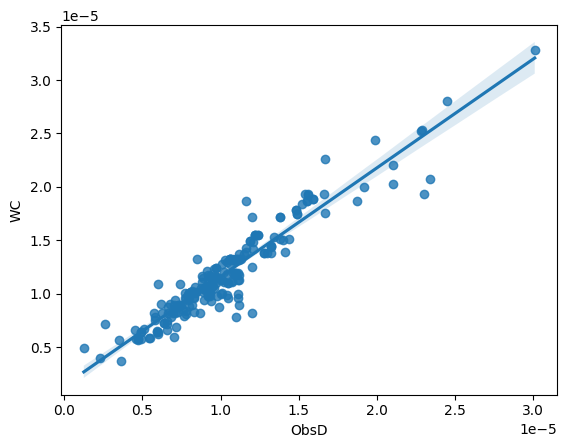

In [25]:
#Obs vs.Wilke-Chang coefficient
#remove missing values so that I can calculate pearsons r
tmp=res[['ObsD','WC']]
#tmp.drop(index=83,axis=0,inplace=True)
tmp=tmp[tmp['ObsD']<5E-5]
tmp.dropna(how='any',inplace=True)
n=len(tmp['ObsD'])

#plot regression
sns.regplot(x=tmp['ObsD'],y=tmp['WC'])

#calculate r2 and p value
r=stats.pearsonr(tmp['ObsD'],tmp['WC'])
#calculate root mean square error
rms = mean_squared_error(tmp['ObsD'], tmp['WC'], squared=False)
print(r)
print('n=',n,'rmse=',rms)

PearsonRResult(statistic=0.9452440917454745, pvalue=6.605852991186775e-111)
n= 226 rmse= 1.788539621837622e-06


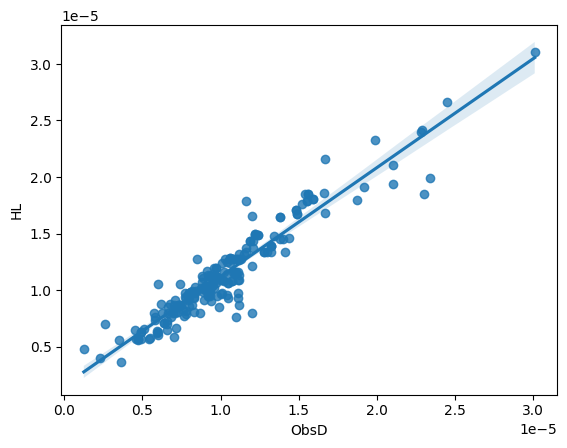

In [26]:
#Obs vs.Hayduk-Laudie coefficient
#remove missing values so that I can calculate pearsons r
tmp=res[['ObsD','HL']]
#tmp.drop(index=83,axis=0,inplace=True)
tmp=tmp[tmp['ObsD']<5E-5]
tmp.dropna(how='any',inplace=True)
n=len(tmp['ObsD'])

#plot regression
sns.regplot(x=tmp['ObsD'],y=tmp['HL'])

#calculate r2 and p value
r=stats.pearsonr(tmp['ObsD'],tmp['HL'])
#calculate root mean square error
rms = mean_squared_error(tmp['ObsD'], tmp['HL'], squared=False)
print(r)
print('n=',n,'rmse=',rms)